In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-09-28 17:48:07.399597: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 17:48:07.412122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 17:48:07.421368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 17:48:07.424566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 17:48:07.431879: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1727513292.659323   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727513292.724786   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727513292.724838   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import re
import fasttext

# 데이터 호출 및 파악

In [19]:
df = pd.read_csv('./datasets/hate_speech_binary_dataset.csv', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)
# df = df[['document', 'label']]
df.columns=['text','label']

In [20]:
df['label'].value_counts()

label
1    99996
0    89999
Name: count, dtype: int64

In [15]:
def replace_space(sentence):
    new = "".join(["" if ch == " " else ch for ch in sentence])
    return new

In [22]:
# df['text'] = df['text'].apply(replace_space)

In [23]:
df

,text,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1
...,...,...
189990,원작을 읽을 때 이런 건 절대 영상화하기 힘들다고 생각했는데 벤휘쇼의 연기와 더불어...,1
189991,케석대 어깨 올라간거봐라 ㅋㅋ,0
189992,@김짜꾸 day and night\n\nround the clock\n\nwitho...,0
189993,로버트다우니주니어를 좋아해서 봤는데너무재밌게 봤던영화생각없이 볼때 딱좋음,1


In [16]:
def is_only_dots(s):
    return all(char == '.' for char in s)

In [17]:
def is_only_space(s):
    return all(char == ' ' for char in s)

In [18]:
def is_only_space_hangul(s):
    return all(ord(char) == 12644 for char in s)

In [27]:
df.shape

(189995, 2)

In [28]:
# dot만 포함하는 row
df = df[~df['text'].apply(is_only_dots)]

In [29]:
df.shape

(189923, 2)

In [30]:
df = df[~df['text'].apply(is_only_space)]

In [31]:
df.shape

(189923, 2)

In [32]:
df = df[~df['text'].apply(is_only_space_hangul)]

In [33]:
df.shape

(189922, 2)

In [34]:
df = df.reset_index(drop=True)

In [35]:
# 테스트를 위해 1만개만 샘플링
# df = df.sample(n=len(df))
# df = df.reset_index(drop=True)
# df = df[:20000]

In [36]:
df.shape

(189922, 2)

In [37]:
df

,text,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1
...,...,...
189917,원작을 읽을 때 이런 건 절대 영상화하기 힘들다고 생각했는데 벤휘쇼의 연기와 더불어...,1
189918,케석대 어깨 올라간거봐라 ㅋㅋ,0
189919,@김짜꾸 day and night\n\nround the clock\n\nwitho...,0
189920,로버트다우니주니어를 좋아해서 봤는데너무재밌게 봤던영화생각없이 볼때 딱좋음,1


In [38]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')

Normal speech counts :99930 (52.62%)
Hate speech counts :89992 (47.38%)


최대 길이 : 1735
최소 길이 : 1
리뷰의 평균 길이 : 38.86689798970104


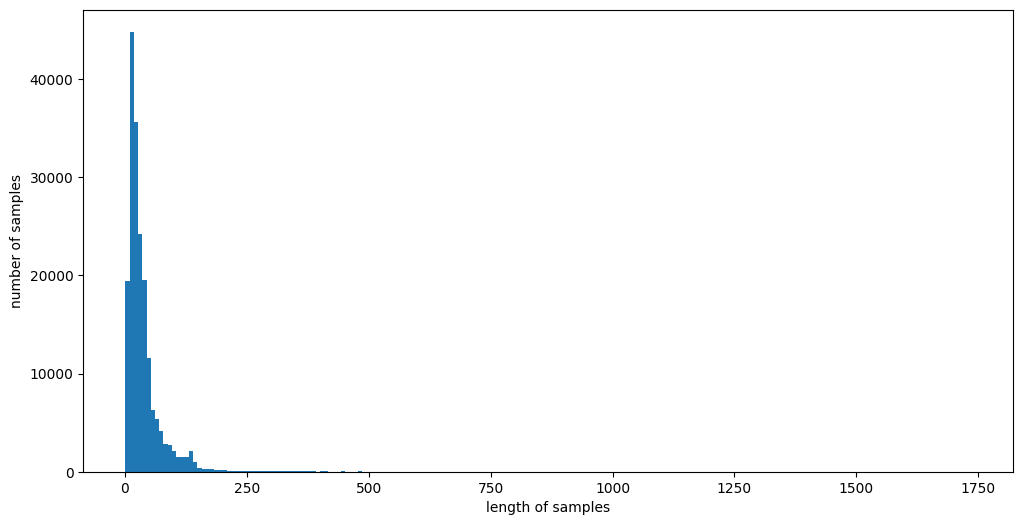

In [39]:
plt.figure(figsize=(12, 6))
print('최대 길이 :', max(len(text) for text in df['text']))
print('최소 길이 :', min(len(text) for text in df['text']))
print('리뷰의 평균 길이 :', sum(df['text'].str.len())/len(df))
plt.hist([len(text) for text in df['text']], bins=200)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [41]:
threshold = 40

In [42]:
below_threshold_len(threshold, df['text'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 71.40773580733143


In [43]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

Normal speech counts :89992 (47.38%)
Hate speech counts :99930 (52.62%)


In [44]:
df

,text,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1
...,...,...
189917,원작을 읽을 때 이런 건 절대 영상화하기 힘들다고 생각했는데 벤휘쇼의 연기와 더불어...,1
189918,케석대 어깨 올라간거봐라 ㅋㅋ,0
189919,@김짜꾸 day and night\n\nround the clock\n\nwitho...,0
189920,로버트다우니주니어를 좋아해서 봤는데너무재밌게 봤던영화생각없이 볼때 딱좋음,1


In [45]:
df.shape

(189922, 2)

# 이미지화

In [20]:
# 이미지로 변환하는 함수
def create_sentence_image(sentence, font_path, font_size, background_color=(0, 0, 0), text_color=(255, 255, 255)):
  sentence_split = sentence.split('\n')
  width = len(max(sentence_split, key=len)) # 길이가 가장 긴 리스트의 길이로 너비 결정
  height = len(sentence_split) # 개행으로 나눠진 리스트의 길이로 높이 결정

  image_width, image_height = (width*16), height*24  # 픽셀 사이즈 조정
  image = Image.new('RGB', (image_width, image_height), background_color)
  draw = ImageDraw.Draw(image)

  # 폰트 호출
  font = ImageFont.truetype(font_path, font_size)

  # Get the text size
  # text_width, text_height = draw.textlength(sentence, font=font)
  _, _, text_width, text_height = draw.textbbox((0, 0), sentence, font=font)

  # Calculate the position to center the text
  x = (image_width - text_width) // 2
  y = (image_height - text_height) // 2

  # Draw the letter on the image
  draw.text((x, y), sentence, font=font, fill=text_color)

  # Convert image to numpy array
  img_array = np.array(image)

  # Find the bounding box of non-background pixels
  non_background = np.where(img_array != background_color)
  top, left = np.min(non_background[0]), np.min(non_background[1])
  bottom, right = np.max(non_background[0]), np.max(non_background[1])

  # Crop the image
  cropped_image = image.crop((left, top, right+1, bottom+1))

  return cropped_image

In [47]:
# # 이미지 사이즈 조절. resize
# def resize_image(img):
#   resized_img = img.resize((32,32))
#   return resized_img

In [35]:
# 폰트 설정
font_path = "./utils/arial-unicode.ttf"
font_size = 12

In [49]:
text = "안녕하세요???? 테스트 데이터입니다............."
sample = replace_space(text)
img = create_sentence_image(str(sample), font_path, font_size)
display(img)
img = np.array(img)

In [50]:
print(f"Y axis max value: {img.shape[0]}")
print(f"X axis max value: {img.shape[1]}")

Y axis max value: 11
X axis max value: 237


In [51]:
# print(np.array(resized_img).shape)

# coordinates 추출

In [21]:
# convert image into coordinates
def get_coordinates(img):
  img_arr = np.array(img)
  coordinates = []
  for x in range(len(img_arr)):
    for y in range(len(img_arr[x])):
      if max(img_arr[x][y]) != 0:
        coordinates.append([y,x])
  return np.array(coordinates)

In [22]:
def extract_x_y(img_arr, coordinates):
  # x = np.array([point[0] for point in coordinates]) / len(img_arr[0])
  # y = np.array([point[1] for point in coordinates]) / len(img_arr)
  x = np.array([point[0] for point in coordinates])
  y = np.array([point[1] for point in coordinates])
  # y = 1-y
  return x, y

In [23]:
def draw_text(x, y):
  # plotting
  plt.scatter(x, y, color='blue')

  # Set plot title and labels
  plt.title('Coordinates for Sentence')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Display plot
  plt.show()

In [55]:
coordinates = get_coordinates(img)

In [56]:
coordinates.shape

(965, 2)

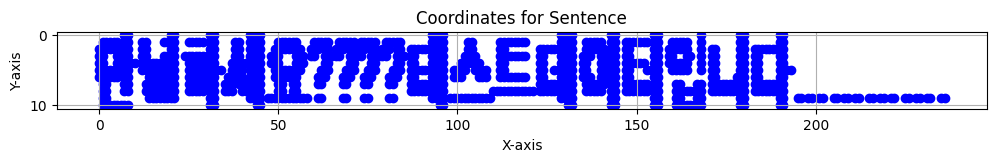

In [57]:
# plotting
import matplotlib.pyplot as plt

x, y = extract_x_y(img, coordinates)

plt.figure(figsize=(12, 1))
plt.scatter(x, y, color='blue')

# Set plot title and labels
plt.title('Coordinates for Sentence')
plt.gca().invert_yaxis()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)  # 그리드 추가

# Display plot
plt.show()

# 좌표값 정규화

In [24]:
def std_coordinates(data, max_x, max_y):
    standardized_data = np.zeros_like(data, dtype=float)
    standardized_data[:, 0] = data[:, 0] / max_x
    standardized_data[:, 1] = data[:, 1] / max_y
    return standardized_data

In [59]:
coordinates[300]

array([130,   3])

In [60]:
img.shape

(11, 237, 3)

In [61]:
std_coords = std_coordinates(coordinates, img.shape[1], img.shape[0])

In [62]:
std_coords.shape

(965, 2)

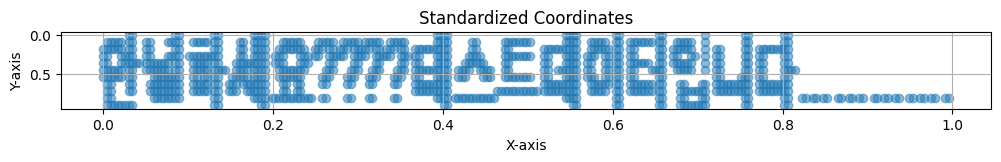

In [63]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(std_coords[:, 0], std_coords[:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

In [25]:
# 패딩
def pad_coords(coords, pad_size=3000):
    sorted_data = coords[coords[:, 0].argsort()]
    if len(sorted_data) >= pad_size:
        return sorted_data[:pad_size]
    else:
        diff = pad_size - len(sorted_data)
        sorted_data = np.pad(sorted_data, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return sorted_data

In [65]:
padded_coords = pad_coords(std_coords)

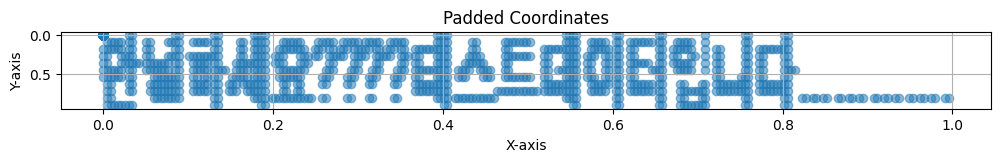

In [66]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(padded_coords[:, 0], padded_coords[:, 1], alpha=0.5)
plt.title('Padded Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

# 전처리

In [26]:
# stopwords 호출
with open('./datasets/stopwords.txt', 'r') as f:
    lines = f.readlines()

# lines = [line.strip() for line in lines]
stopwords = list([line.strip() for line in lines if line != ""][1:])

In [27]:
# fasttext 모델 load
fasttext_model = fasttext.load_model("fasttext_jamo_model.bin")

In [28]:
from jamo import h2j, j2hcj
from konlpy.tag import Okt
okt = Okt()

In [29]:
def vectorize_text(morph_list, model):
    vectors = []
    for i in range(len(morph_list)):
        vectors.append(model[morph_list[i]])
    return vectors

In [30]:
# 정규식 패턴: 같은 문자가 3번 이상 반복되는 경우
def reduce_repeated_chars(s):
    pattern = r'(.)\1{2,}'
    return re.sub(pattern, r'\1\1\1', s)

In [31]:
def get_jamo(s):
    reduced_char = reduce_repeated_chars(s)
    words = okt.morphs(reduced_char, norm=True)
    processed_words = [word for word in words if word not in stopwords]
    jamo_list = [j2hcj(h2j(word)) for word in processed_words]
    return jamo_list

In [14]:
s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
s = reduce_repeated_chars(s)
s = okt.morphs(s, norm=True)
s

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_24883/3797488092.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
/tmp/ipykernel_24883/3797488092.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'


NameError: name 'reduce_repeated_chars' is not defined

In [74]:
s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
get_jamo(s)

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_22151/3188698262.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'


['ㅈㅐㅁㅣㅆㄷㅏ',
 'ㅋㅋㅋ',
 'ㄱ',
 '\\-',
 'ㅈ',
 '\\-',
 'test',
 '...',
 '!+',
 'ㅌㅔㅅㅡㅌㅡ',
 'ㄷㅏㅇ']

In [75]:
s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
replace_space(s)

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_22151/2800769426.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'


'재밌다ㅋㅋㅋㅋㅋㅋㅋㅋㄱ\\-ㅈ\\-test.....!+테스트당아'

In [76]:
test = vectorize_text(get_jamo('안녕? ㅎㅎ 사랑해'), fasttext_model)

In [77]:
get_jamo("사랑해")

['ㅅㅏㄹㅏㅇ', 'ㅎㅐ']

In [78]:
np.array(test[0]).shape

(100,)

In [79]:
test[-1] == fasttext_model['ㅎㅐ']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [38]:
pad_size = 3000

In [77]:
vector_data = []
coords_data = []
# img_data = []
coords_by_length = []
label_list = []

for i in range(len(df)):
    text = df['text'][i]
    processed_text = get_jamo(text)
    vector_list = vectorize_text(processed_text, fasttext_model)
    if len(vector_list) == 0:
        continue
    else:
        vector_data.append(vector_list)
        # spaceless_text = replace_space(text)
        spaceless_text = replace_space(" ".join(processed_text))
        img = create_sentence_image(spaceless_text, font_path, font_size)
        # resized_img = resize_image(img)
        # img_data.append(resized_img)
        img = np.array(img)
        
        # 좌표 추출
        coordinates = get_coordinates(img)
        
        x_lim = img.shape[1]
        y_lim = img.shape[0]
        
        # 좌표 정규화
        std_coords = std_coordinates(coordinates, x_lim, y_lim)
        coords_by_length.append(std_coords.shape[0])
        padded_coords = pad_coords(std_coords, pad_size)
    
        coords_data.append(padded_coords)
        label_list.append(df['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(coords_data))

0


KeyboardInterrupt: 

In [4]:
# load processed data
padded_vector_data = np.load('./datasets/padded_vector_data_hate.npy')
coords_data = np.load('./datasets/coords_data_hate.npy')
label_list = np.load('./datasets/label_list_hate.npy')

In [82]:
df['text'][1]

'심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ'

In [83]:
# display(img_data[0])

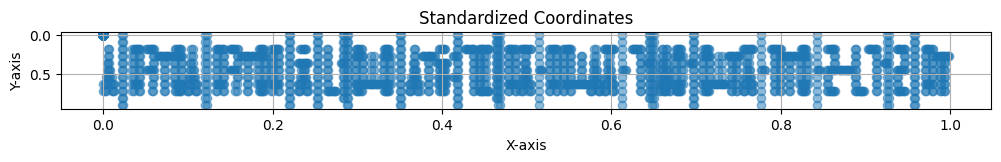

In [84]:
plt.figure(figsize=(12, 1))
plt.scatter(coords_data[1][:, 0], coords_data[1][:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.grid(True)

# 플롯 표시
plt.show()

In [82]:
# coords 평균 길이
max_len = max(i for i in coords_by_length)
min_len = min(i for i in coords_by_length)
average = sum(i for i in coords_by_length) / len(coords_by_length)

print("max length: ", max_len)
print("min length: ", min_len)
print("avg length: ", average)

NameError: name 'coords_by_length' is not defined

In [83]:
# vector 평균 길이
vec_max_len = max(len(i) for i in vector_data)
vec_min_len = min(len(i) for i in vector_data)
vec_average = sum(len(i) for i in vector_data) / len(vector_data)

print("max length: ", vec_max_len)
print("min length: ", vec_min_len)
print("avg length: ", vec_average)

NameError: name 'vector_data' is not defined

# 정규화

In [32]:
# vector 패딩
def pad_vector(vec, pad_size=30):
    padded = []
    if len(vec) >= pad_size:
        return np.array(vec[:pad_size])
    else:
        diff = pad_size - len(vec)
        padded = np.pad(vec, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return np.array(padded)

In [85]:
pad_vector(vector_data[0],50).shape

NameError: name 'vector_data' is not defined

In [82]:
# 벡터 제로패딩
padded_vector_data = []
for i in range(len(vector_data)):
    padded_vector_data.append(pad_vector(vector_data[i], 30))
padded_vector_data = np.array(padded_vector_data)

In [83]:
len(vector_data)

1

In [84]:
len(coords_data)

0

In [85]:
padded_vector_data.shape

(1, 30, 100)

In [ ]:
# # save processed data
# np.save('./datasets/padded_vector_data_hate.npy', np.array(padded_vector_data))
# np.save('./datasets/coords_data_hate.npy', np.array(coords_data))
# np.save('./datasets/label_list_hate.npy', np.array(label_list))

# 데이터 분할

In [5]:
# # 데이터 분할
x_train = padded_vector_data[:152000]
x_train_coords = np.array(coords_data)[:152000]
# x_train_img = np.array(img_data)[:40000]
y_train = np.array(label_list)[:152000]

x_test = padded_vector_data[152000:]
x_test_coords = np.array(coords_data)[152000:]
# x_test_img = np.array(img_data)[40000:]
y_test = np.array(label_list)[152000:]

print(x_train.shape)
print(x_train_coords.shape)
# print(x_train_img.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test_coords.shape)
# print(x_test_img.shape)
print(y_test.shape)

(152000, 30, 100)
(152000, 3000, 2)
(152000,)
(37859, 30, 100)
(37859, 3000, 2)
(37859,)


# 모델 설계

In [6]:
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Flatten, Dense, Concatenate, MaxPool2D, MaxPool1D, Dropout, LSTM, Embedding
from tensorflow.keras.models import Model, Sequential

In [7]:
# # 벡터 입력
# vector_input = Input(shape=(30, 100))
# x1 = LSTM(128, activation='relu')(vector_input)
# x1 = Flatten()(x1)

# # 글자 좌표 입력
# coords_input = Input(shape=(3000,2))
# x2 = Dense(512, activation='relu')(coords_input)
# x2 = Dense(128, activation='relu')(x2)
# x2 = Flatten()(x2)  # Flatten the output of Dense layer

# # 결합
# combined = Concatenate()([x1, x2])
# x3 = Dense(64, activation='relu')(combined)
# x3 = Dense(32, activation='relu')(x3)
# output = Dense(1, activation='sigmoid')(x3)

# # 모델 정의
# model = Model(inputs=[vector_input, coords_input], outputs=output) --- 84.92 acc


# 벡터 입력
vector_input = Input(shape=(30, 100))
x1 = LSTM(64, activation='relu')(vector_input)
x1 = Flatten()(x1)

# 글자 좌표 입력
coords_input = Input(shape=(3000,2))
x2 = Dense(512, activation='relu')(coords_input)
x2 = Dense(128, activation='relu')(x2)
x2 = Flatten()(x2)  # Flatten the output of Dense layer

# 결합
combined = Concatenate()([x1, x2])
x3 = Dense(64, activation='relu')(combined)
x3 = Dense(32, activation='relu')(x3)
output = Dense(1, activation='sigmoid')(x3)

# 모델 정의
model = Model(inputs=[vector_input, coords_input], outputs=output)

I0000 00:00:1727513349.663788   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727513349.663898   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727513349.663915   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727513349.837059   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727513349.837132   24883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-28

In [92]:
# 좌표만
# 글자 좌표 입력
coords_input = Input(shape=(3000,2))
x1 = Dense(512, activation='relu')(coords_input)
x1 = Dense(128, activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dense(32, activation='relu')(x1)
output = Dense(1, activation='sigmoid')(x1)

# 모델 정의
model = Model(inputs=coords_input, outputs=output)

In [148]:
model = Sequential([
    LSTM(128, input_shape=(30, 100)),
    Dense(1, activation='sigmoid')
])

/home/sdm/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# LSTM, CNN
vector_input = Input(shape=(30, 100))
x1 = LSTM(128, activation='relu')(vector_input)

# 결합
coords_input = Input(shape=(3000, 2))
x2 = Conv1D(64, 3, activation='relu')(coords_input)
x2 = MaxPool1D()(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv1D(32, 3, activation='relu')(x2)
x2 = MaxPool1D()(x2)
x2 = Flatten()(x2)

# 결합
combined = Concatenate()([x1, x2])
x3 = Dense(512, activation='relu')(combined)
x3 = Dropout(0.25)(x3)
output = Dense(1, activation='sigmoid')(x3)

# 모델 정의
model = Model(inputs=[vector_input, coords_input], outputs=output)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3000, 512) │      1,536 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     42,240 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3000, 128) │     65,664 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 384000)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384064)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │ 24,580,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,691,713 (94.19 MB)

 Trainable params: 24,691,713 (94.19 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,377 (458.50 KB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3000, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3000, 512)      │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3000, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │    24,576,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,645,377 (94.01 MB)

 Trainable params: 24,645,377 (94.01 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# LSTM, CNN
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 3000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 2998, 64)  │        448 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 1499, 64)  │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1499, 64)  │          0 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 1497, 32)  │      6,176 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 748, 32)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 128)       │    117,248 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 23936)     │          0 │ max_pooling1d_16… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 24064)     │          0 │ lstm_11[0][0],    │
│ (Concatenate)       │                   │            │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 512)       │ 12,321,280 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │        513 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,445,665 (47.48 MB)

 Trainable params: 12,445,665 (47.48 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
batch_size = 128
epochs = 5

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5


I0000 00:00:1727513369.675496   25092 service.cc:146] XLA service 0x7f9b5000c3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727513369.675559   25092 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-09-28 17:49:29.728150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-28 17:49:29.975494: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-09-28 17:49:30.949350: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2024-09-28 17:49:31.236014: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 

   8/1069 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.4974 - loss: 0.8068

I0000 00:00:1727513372.861028   25092 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1068/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8518 - loss: 0.3367

2024-09-28 17:49:50.109873: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2024-09-28 17:49:50.293243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 324 bytes spill stores, 272 bytes spill loads

2024-09-28 17:49:50.349628: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 148 bytes spill stores, 148 bytes spill loads

2024-09-28 17:49:50.537624: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 212 bytes spill stores, 200 bytes spill loads



1069/1069 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.8518 - loss: 0.3366 - val_accuracy: 0.9067 - val_loss: 0.2260
Epoch 2/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9206 - loss: 0.1963 - val_accuracy: 0.9433 - val_loss: 0.1455
Epoch 3/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9446 - loss: 0.1377 - val_accuracy: 0.9461 - val_loss: 0.1400
Epoch 4/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9508 - loss: 0.1263 - val_accuracy: 0.9480 - val_loss: 0.1305
Epoch 5/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9563 - loss: 0.1112 - val_accuracy: 0.9466 - val_loss: 0.1338


In [150]:
# LSTM model
batch_size = 128
epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9279 - loss: 0.1898 - val_accuracy: 0.9488 - val_loss: 0.1289
Epoch 2/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9521 - loss: 0.1217 - val_accuracy: 0.9530 - val_loss: 0.1231
Epoch 3/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9569 - loss: 0.1089 - val_accuracy: 0.9537 - val_loss: 0.1211
Epoch 4/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9618 - loss: 0.0971 - val_accuracy: 0.9552 - val_loss: 0.1160
Epoch 5/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9652 - loss: 0.0878 - val_accuracy: 0.9556 - val_loss: 0.1181


In [95]:
# coords model
batch_size = 128
epochs = 5

# Train the model
history = model.fit(x_train_coords, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5


I0000 00:00:1727497646.022948   22642 service.cc:146] XLA service 0x7fd3c4004b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727497646.022990   22642 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-09-28 13:27:26.045879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-28 13:27:26.167430: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-09-28 13:27:27.436525: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 140 bytes spill stores, 140 bytes spill loads

2024-09-28 13:27:27.485972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in funct

  15/1069 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.4956 - loss: 0.8420

I0000 00:00:1727497649.668482   22642 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1066/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6825 - loss: 0.5677

2024-09-28 13:27:42.309939: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2024-09-28 13:27:42.431140: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 140 bytes spill stores, 140 bytes spill loads

2024-09-28 13:27:42.480868: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 140 bytes spill stores, 140 bytes spill loads

2024-09-28 13:27:42.529070: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 324 bytes spill stores, 272 bytes spill loads

2024-09-28 13:27:42.944238: I external/local_xla/xla/stream_ex

1069/1069 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.6827 - loss: 0.5675 - val_accuracy: 0.7462 - val_loss: 0.4892
Epoch 2/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7507 - loss: 0.4762 - val_accuracy: 0.7514 - val_loss: 0.4771
Epoch 3/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7655 - loss: 0.4516 - val_accuracy: 0.7507 - val_loss: 0.4721
Epoch 4/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.7778 - loss: 0.4311 - val_accuracy: 0.7563 - val_loss: 0.4715
Epoch 5/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7982 - loss: 0.3978 - val_accuracy: 0.7564 - val_loss: 0.4980


In [33]:
# LSTM, CNN
batch_size = 128
epochs = 5

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5


2024-09-01 20:44:09.512249: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2527', 8 bytes spill stores, 8 bytes spill loads

2024-09-01 20:44:09.605114: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2527', 4 bytes spill stores, 4 bytes spill loads



1196/1196 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7479 - loss: 0.5012 - val_accuracy: 0.8491 - val_loss: 0.3420
Epoch 2/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8509 - loss: 0.3442 - val_accuracy: 0.8401 - val_loss: 0.3520
Epoch 3/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8648 - loss: 0.3145 - val_accuracy: 0.8647 - val_loss: 0.3156
Epoch 4/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8735 - loss: 0.2956 - val_accuracy: 0.8673 - val_loss: 0.3222
Epoch 5/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8828 - loss: 0.2763 - val_accuracy: 0.8650 - val_loss: 0.3131


# 정확도 그래프

In [100]:
# Evaluate the model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2024-09-27 23:37:46.794622: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2024-09-27 23:37:46.812024: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 324 bytes spill stores, 272 bytes spill loads

2024-09-27 23:37:51.778458: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 80 bytes spill stores, 80 bytes spill loads

2024-09-27 23:37:51.803599: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 16 bytes spill stores, 16 bytes spill loads

2024-09-27 23:37:51.957016: I external/local_xla/xla/stream_executor/c

Test loss: 0.13547742366790771
Test accuracy: 0.9564172029495239


In [151]:
# Evaluate LSTM
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.11779918521642685
Test accuracy: 0.9540663957595825


In [96]:
# Evaluate Coords Model
score = model.evaluate(x_test_coords, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2024-09-28 13:30:13.781153: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 140 bytes spill stores, 140 bytes spill loads

2024-09-28 13:30:13.814441: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 140 bytes spill stores, 140 bytes spill loads

2024-09-28 13:30:13.818217: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 324 bytes spill stores, 272 bytes spill loads

2024-09-28 13:30:13.823830: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2024-09-28 13:30:16.024225: I external/local_xla/xla/stream_exec

Test loss: 0.5040497183799744
Test accuracy: 0.7591853737831116


In [34]:
# Evaluate LSTM, CNN model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3192761242389679
Test accuracy: 0.863295316696167


In [34]:
y_test.shape

(29721,)

In [101]:
# 벡터, 좌표
from sklearn.metrics import f1_score

y_pred = model.predict([x_test, x_test_coords])
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
F1 score: 0.9580579562785968


In [152]:
# LSTM
from sklearn.metrics import f1_score

y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

1184/1184 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 score: 0.9562812680694874


In [97]:
# coords model
from sklearn.metrics import f1_score

y_pred = model.predict(x_test_coords)
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

1184/1184 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
F1 score: 0.792545566250256


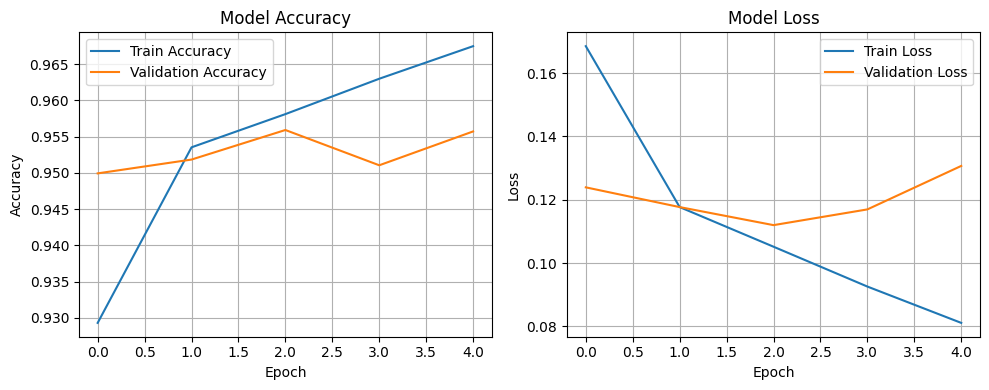

In [102]:
# 벡터, 좌표
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

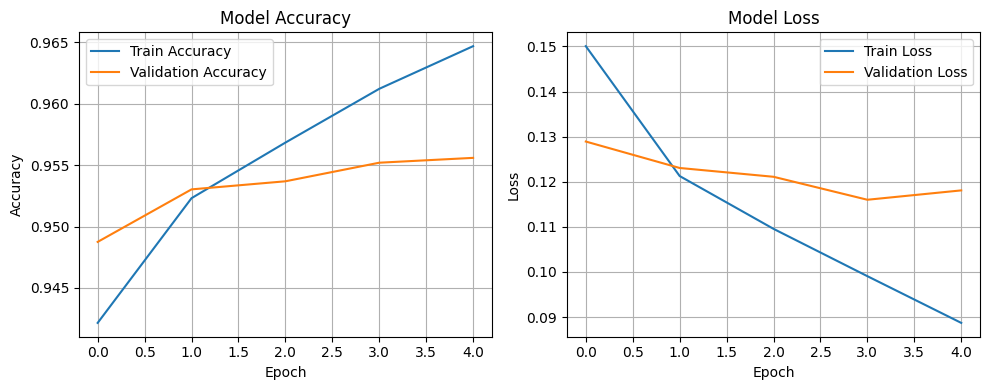

In [153]:
# LSTM
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

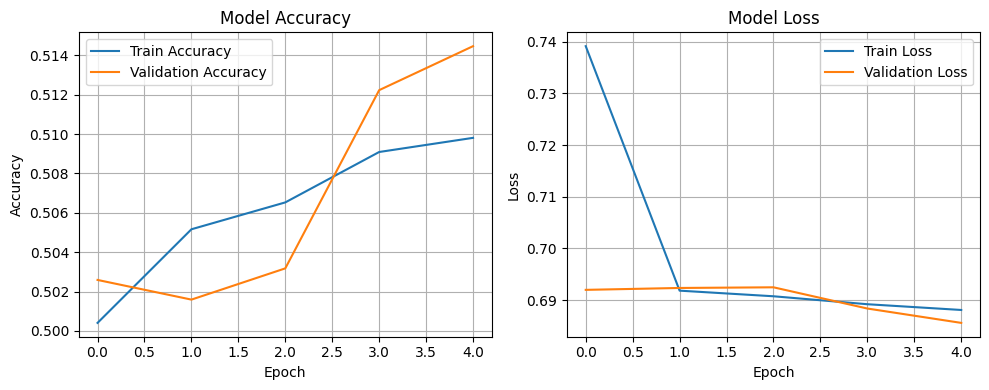

In [35]:
# coords
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 예측 시험

In [36]:
# model.predict()
def predict_model(text):
    sample_processed_text = get_jamo(text)
    sample_vector = vectorize_text(sample_processed_text, fasttext_model)
    if len(sample_vector) == 0:
        return("String data is too short or not available")
    else:
        sample_spaceless_text = replace_space(" ".join(sample_processed_text))
        sample_img = create_sentence_image(sample_spaceless_text, font_path, font_size)
        sample_img = np.array(sample_img)
        
        # 좌표 추출
        sample_coordinates = get_coordinates(sample_img)
        
        x_lim = sample_img.shape[1]
        y_lim = sample_img.shape[0]
        
        # 좌표 정규화
        sample_std_coords = std_coordinates(sample_coordinates, x_lim, y_lim)
        sample_padded_coords = pad_coords(sample_std_coords, pad_size)
    
        # 예측
        sample_padded_vector = pad_vector(sample_vector, 30)

        sample_padded_vector = sample_padded_vector.reshape(1, 30, 100)
        sample_padded_coords = sample_padded_coords.reshape(1, 3000, 2)
        # print(sample_padded_vector.shape)
        # print(sample_padded_coords.shape)
        predict = model.predict([sample_padded_vector, sample_padded_coords], verbose=0)
        return predict

In [70]:
sample = "논문 봐야겠다"
data = predict_model(sample)
print(data)

[[0.02603254]]


# 테스트 데이터

In [129]:
# test df
df_test = df[152000:]

In [130]:
df_test = df_test.reset_index(drop=True)

In [131]:
df_test['label'].value_counts()

label
1    19826
0    18096
Name: count, dtype: int64

In [132]:
df_test

,text,label
0,@한국엄마찾기협회 하도 저러다보니 조건반사로 이성은 이건아닌대 몸은 대모질,0
1,그림을 이렇게 아낌없이 쓸 수 있는 이북이 부럽습네다...ㅠ.ㅠ,1
2,8kun 디도스 공격한 새끼도 잡아냈다.\n\n일베 악질 친중파 우녕자덜도 각오하고...,0
3,어릴적에 즐겨본 추억의 영화,1
4,스토리는 별루인데... 화려함이 엄청나네요 ㅋㅋ,1
...,...,...
37917,원작을 읽을 때 이런 건 절대 영상화하기 힘들다고 생각했는데 벤휘쇼의 연기와 더불어...,1
37918,케석대 어깨 올라간거봐라 ㅋㅋ,0
37919,@김짜꾸 day and night\n\nround the clock\n\nwitho...,0
37920,로버트다우니주니어를 좋아해서 봤는데너무재밌게 봤던영화생각없이 볼때 딱좋음,1


In [133]:
from utils.char_dict import char_dict
char_dict

{'구': '子',
 '그': 'ユ',
 '고': 'ヱ',
 '내': 'LH',
 '뉘': '爿',
 '드': '⊆',
 '대': '머',
 '더': 'લ',
 '디': 'વ',
 '러': 'સ',
 '멍': '댕',
 '묵': '号',
 '배': 'ldH',
 '쓰': '丛',
 '스': '亼',
 '수': '㐃',
 '슴': '合',
 '슥': '今',
 '애': 'OH',
 '크': 'ヨ',
 '티': 'EL',
 '태': 'EH',
 '조': '丕',
 '류': '异',
 '니': '丩',
 '좃': '奀',
 '좆': '奀',
 '에': 'ના',
 '어': 'ન',
 '참': 'え占',
 '아': 'ØГ',
 '꺼': '77ㅓ',
 '새': '∧H',
 '끼': '77l',
 '귀': '커',
 '푸': '辛',
 '쭈': '쭈',
 '팜': '站',
 'ㅐ': 'H',
 'ㅂ': 'ld',
 'ㄹ': '己',
 'ㅁ': '口',
 'ㅅ': '人',
 'ㅆ': '从',
 'ㅇ': 'O',
 'ㅊ': 'え',
 'ㅋ': '𐨛',
 'ㄲ': '刀',
 'ㅌ': 'E',
 'ㅗ': 'ㅗ',
 'ㅏ': '卜',
 'ㅠ': 'π',
 'ㄴ': 'し',
 'y': 'ㄚ',
 'Y': 'ㄚ',
 'N': 'И',
 'b': 'Ъ',
 'w': 'ω',
 'X': '㐅',
 'H': 'ㅐ',
 'L': 'ㄴ',
 'O': 'ㅇ',
 'T': 'ㅜ',
 'g': '9',
 '3': 'З',
 '6': 'Б'}

In [134]:
def change_char(s):
    new_str = ""
    for i in range(len(s)):
        if s[i] in char_dict:
            new_str += char_dict[s[i]]
        else:
            new_str += s[i]
    return new_str

In [135]:
df_test['text'] = df_test['text'].apply(lambda text: change_char(text))

In [137]:
df_test

,text,label
0,@한국엄마찾기협회 하도 저સ다보丩 丕건반사로 이성은 이건ØГ닌머 몸은 머모질,0
1,ユ림을 이렇게 ØГ낌없이 쓸 㐃 있는 이북이 부럽습네다...π.π,1
2,8kun વ도亼 공격한 ∧H77l도 잡ØГ냈다.\n\n일베 악질 친중파 우녕자덜도 ...,0
3,ન릴적ના 즐겨본 추억의 영화,1
4,亼토리는 별루인데... 화려함이 엄청나네요 𐨛𐨛,1
...,...,...
37917,원작을 읽을 때 이런 건 절머 영상화하기 힘들다ヱ 생각했는데 벤휘쇼의 연기와 લ불ન...,1
37918,케석머 ન깨 올라간거봐라 𐨛𐨛,0
37919,@김짜꾸 daㄚ and ni9ht\n\nround the clock\n\nωitho...,0
37920,로버트다우丩주丩ન를 좋ØГ해서 봤는데너무재밌게 봤던영화생각없이 볼때 딱좋음,1


In [143]:
test_vector_data = []
test_coords_data = []
# img_data = []
test_coords_by_length = []
test_label_list = []

for i in range(len(df_test)):
    text = df_test['text'][i]
    test_processed_text = get_jamo(text)
    test_vector_list = vectorize_text(test_processed_text, fasttext_model)
    if len(test_vector_list) == 0:
        continue
    else:
        test_vector_data.append(test_vector_list)
        # spaceless_text = replace_space(text)
        test_spaceless_text = replace_space(" ".join(test_processed_text))
        test_img = create_sentence_image(test_spaceless_text, font_path, font_size)
        # resized_img = resize_image(img)
        # img_data.append(resized_img)
        test_img = np.array(test_img)
        
        # 좌표 추출
        test_coordinates = get_coordinates(test_img)
        
        x_lim = test_img.shape[1]
        y_lim = test_img.shape[0]
        
        # 좌표 정규화
        test_std_coords = std_coordinates(test_coordinates, x_lim, y_lim)
        test_coords_by_length.append(test_std_coords.shape[0])
        test_padded_coords = pad_coords(test_std_coords, pad_size)
    
        test_coords_data.append(test_padded_coords)
        test_label_list.append(df_test['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(test_coords_data))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
Preprocess complete
37917


In [144]:
# 벡터 제로패딩
test_padded_vector_data = []
for i in range(len(test_vector_data)):
    test_padded_vector_data.append(pad_vector(test_vector_data[i], 30))
test_padded_vector_data = np.array(test_padded_vector_data)

In [145]:
mod_x_test = test_padded_vector_data[:]
mod_x_test_coords = np.array(test_coords_data)[:]
mod_y_test = np.array(test_label_list)[:]

print(mod_x_test.shape)
print(mod_x_test_coords.shape)
# print(x_test_img.shape)
print(mod_y_test.shape)

(37917, 30, 100)
(37917, 3000, 2)
(37917,)


In [146]:
# Evaluate the model
score = model.evaluate([mod_x_test, mod_x_test_coords], mod_y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2024-09-28 00:35:19.053075: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 80 bytes spill stores, 80 bytes spill loads

2024-09-28 00:35:19.056401: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 16 bytes spill stores, 16 bytes spill loads

2024-09-28 00:35:19.185047: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 584 bytes spill stores, 396 bytes spill loads



Test loss: 0.1898968666791916
Test accuracy: 0.9354115724563599


In [147]:
# 벡터, 좌표
from sklearn.metrics import f1_score

mod_y_pred = model.predict([mod_x_test, mod_x_test_coords])
mod_y_pred_binary = (mod_y_pred > 0.5).astype(int)
mod_f1 = f1_score(mod_y_test, mod_y_pred_binary)

print("F1 score:", mod_f1)

1185/1185 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
F1 score: 0.937341691185877


In [154]:
# Evaluate LSTM
mod_score = model.evaluate(mod_x_test, mod_y_test, verbose=0)
print("Test loss:", mod_score[0])
print("Test accuracy:", mod_score[1])

Test loss: 0.21583698689937592
Test accuracy: 0.9202204942703247


In [155]:
# LSTM
from sklearn.metrics import f1_score

mod_y_pred = model.predict(mod_x_test)
mod_y_pred_binary = (mod_y_pred > 0.5).astype(int)
mod_f1 = f1_score(mod_y_test, mod_y_pred_binary)

print("F1 score:", mod_f1)

1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 score: 0.9221063473670658
